In [1]:
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize

import glob
from scipy.stats.kde import gaussian_kde
from numpy import linspace
import time
from scipy import interpolate
import seaborn as sns

from ipywidgets import IntProgress
from IPython.display import display

In [2]:
#Set latex environment for plots/labels
# matplotlib.rc('font', **{'family': 'serif'})
matplotlib.rc('text', usetex=False)
matplotlib.rcParams['text.latex.preamble'] = [r'\boldmath']
plt.rcParams.update({'font.family':'serif'})


fl=22
fm=18
fs=16


In [3]:
from natal_kick_tools import mandel_muller_likelihood_functions as mmf
from natal_kick_tools import likelihood_plot_functions as lpf

In [4]:
# this is just a little function that we will use to make the plot more beautiful (bigger ticks, labels)
# However, you do not have to use this (just uncommoment "layoutAxes" everywhere)
from matplotlib.ticker import (FormatStrFormatter,
                               AutoMinorLocator)

def layoutAxes(ax, nameX='', nameY='', \
               labelSizeMajor = 10, fontsize = fm, second=False, labelpad=None, setMinor=True):
#     matplotlib.rc('font', **{'family': 'serif'})

    """
    Tiny code to do the layout for axes in matplotlib
    """
    tickLengthMajor = 10
    tickLengthMinor = 5
    tickWidthMajor  = 1.5
    tickWidthMinor  = 1.5
    
    #rc('axes', linewidth=2)
    #label1 always refers to first axis not the twin 
    if not second:
        for tick in ax.xaxis.get_major_ticks():
            tick.label1.set_fontsize(fontsize)
            #tick.label1.set_fontweight('bold')
        for tick in ax.yaxis.get_major_ticks():
            tick.label1.set_fontsize(fontsize)
            #tick.label1.set_fontweight('bold')
    if second:
        for tick in ax.xaxis.get_major_ticks():
            tick.label2.set_fontsize(fontsize)
            #tick.label1.set_fontweight('bold')
        for tick in ax.yaxis.get_major_ticks():
            tick.label2.set_fontsize(fontsize)
            #tick.label1.set_fontweight('bold')
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.2)
    ax.tick_params(length=tickLengthMajor, width=tickWidthMajor, which='major')
    ax.tick_params(length=tickLengthMinor, width=tickWidthMinor, which='minor')
    ax.set_xlabel(nameX, fontsize=fontsize,labelpad=labelpad)#,fontweight='bold')
    ax.set_ylabel(nameY, fontsize=fontsize,labelpad=labelpad)#, fontweight='bold')    
    
    if setMinor==True:
        # add minor ticks:
        ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.yaxis.set_minor_locator(AutoMinorLocator())

    return ax


In [5]:
# Define the models of interest
bh_kicks=[200]
ns_kicks = [400, 450, 500, 550, 600, 650]
sigmas = [0.1, 0.2, 0.3, 0.4, 0.5]

# Define the location of the posterior data
pulsar_data_loc = "../correctedPulsarPosteriors/correctedVtData"

# Read Velocity Data

## Model Velocities

In [6]:
# Define a dictionary to map v_ns and sigma to their arrays
kick_models = {}
sig = len(sigmas)
vns = len(ns_kicks)

for i in range(len(ns_kicks)):
    kick_models[f"NS_{ns_kicks[i]}_RANGE"] = np.arange(i*sig, (i*sig)+sig, 1)

for i in range(len(sigmas)):
    kick_models[f"SIGMA_{sigmas[i]}_RANGE"] = np.arange(i, (vns*sig) + i, sig)

kick_models["ALL"] = np.arange(0, vns*sig, 1)

In [7]:
# Read model velocity data (takes ~2 min)

start = time.time()

NS_KICKS_3D = []
NS_KICKS_2D = []
NS_KICK_MULT = [] 
SIGMAS = []

f = IntProgress(min=0, max=sig*vns) # instantiate the bar
display(f) # display the bar

for ns_kick in ns_kicks:
    for sigma in sigmas:
        f.value +=1
        fname = f"model_velocities_bse/vns_{ns_kick}_sigma_{sigma}_velocities"
        v_3d, v_2d = np.loadtxt(fname, skiprows=1, unpack=True)
        NS_KICKS_3D.append(v_3d)
        NS_KICKS_2D.append(v_2d)
        NS_KICK_MULT.append(ns_kick)
        SIGMAS.append(sigma)    
        
end = time.time()
print(end - start, "s")

IntProgress(value=0, max=30)

73.0592930316925 s


# Read Likelihood Data

In [8]:
p_models = []
columns = [] # labels for plotting model likelihoods in next cell
for ns_kick in ns_kicks:
    for sigma in sigmas:
        fname = f"calculatedModelLikelihoods_bse/vns_{ns_kick}_sigma_{sigma}"
        all_likelihoods = np.loadtxt(fname)
        p_models.append(np.prod(all_likelihoods))
        
        col_name = f"vns_{ns_kick}_sigma_{sigma}"
        columns.append(col_name)

# normalize and reshape the array
p_models = p_models/np.max(p_models)

p_models_2d = p_models.reshape([len(ns_kicks), len(sigmas)])
print(np.array2string(p_models_2d, formatter={'float_kind': '{0:.3f}'.format}))

[[0.001 0.007 0.015 0.008 0.003]
 [0.009 0.088 0.162 0.098 0.022]
 [0.027 0.228 0.521 0.335 0.084]
 [0.061 0.417 1.000 0.427 0.073]
 [0.034 0.288 0.683 0.302 0.040]
 [0.009 0.075 0.190 0.127 0.015]]


In [9]:
# Identify the 3 most likely models
M = sorted(zip(p_models), reverse=True)[:5]
MAX_INDICES = np.where(p_models==M)[1]

labels = []
for i in range(len(MAX_INDICES)):
    labels.append("$v_{ns}$=" + f"{NS_KICK_MULT[MAX_INDICES[i]]}" + ", $\sigma_{ns}$=" + f"{SIGMAS[MAX_INDICES[i]]}")

# Load Posterior Data

In [10]:
# Takes about 30 s
start = time.time()

vt_all = []

f = IntProgress(min=0, max=len(glob.glob('../correctedPulsarPosteriors/correctedVtData/*.bootstraps'))) # instantiate the bar
display(f) # display the bar

for file in glob.glob('../correctedPulsarPosteriors/correctedVtData/*.bootstraps'):
    f.value +=1
    vt_all.append(np.loadtxt(file, unpack=True, usecols=5))

end = time.time()
print(end - start, "s")

IntProgress(value=0, max=81)

36.961689710617065 s


In [11]:
PLOT_DATA = [vt_all, NS_KICKS_2D, NS_KICK_MULT, SIGMAS] # Needed to make all the cdf functions work

# PDF and CDF Plots

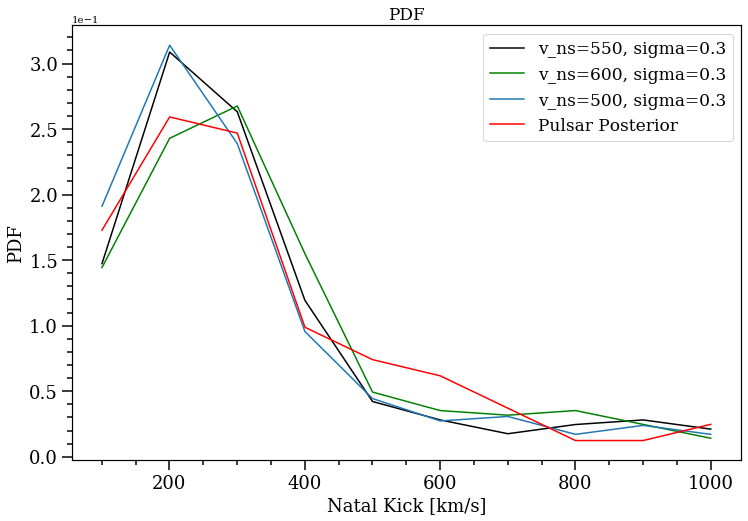

In [12]:
f, ax= plt.subplots(1, 1,  figsize=(12,8)) 

lpf.plot_model_pdf(*PLOT_DATA, MAX_INDICES[0], color='k')
lpf.plot_model_pdf(*PLOT_DATA, MAX_INDICES[1], color='g')
lpf.plot_model_pdf(*PLOT_DATA, MAX_INDICES[2], color='C0')

lpf.plot_posterior_pdf(*PLOT_DATA, color='r')


layoutAxes(ax=ax, nameX='Natal Kick [km/s]',\
           nameY='PDF')

plt.ticklabel_format(axis='y', style='sci',scilimits=(0,0))

plt.title(f"PDF", fontsize=17)

leg = plt.legend(fontsize=17)
for lh in leg.legendHandles: 
    lh.set_alpha(1)
    
    
# plt.semilogx()
plt.show()


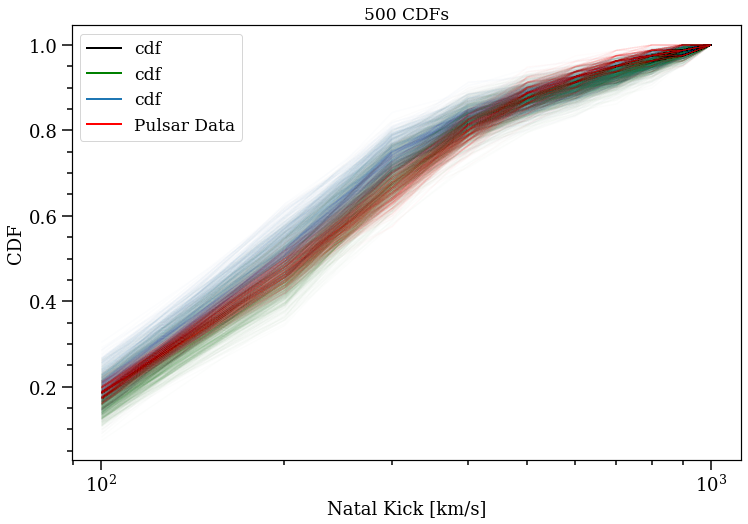

Plot completed in 25.239759 s


In [13]:
n_cdf = 500
n_draws = 200
alpha = 5/n_cdf

f, ax= plt.subplots(1, 1,  figsize=(12,8)) 

start = time.time()

lpf.plot_model_cdf(*PLOT_DATA, n_cdf, MAX_INDICES[0], n_draws=n_draws, color='k', alpha=alpha)
lpf.plot_model_cdf(*PLOT_DATA, n_cdf, MAX_INDICES[1], n_draws=n_draws, color='g', alpha=alpha)
lpf.plot_model_cdf(*PLOT_DATA, n_cdf, MAX_INDICES[2], n_draws=n_draws, color='C0', alpha=alpha)

# Posterior CDF always contains len(vt_all) data points in current implementation. 
# See 'draw_posterior_cdf' function for alternate implementation with n_draws data points
lpf.plot_posterior_cdf(*PLOT_DATA, n_cdf, n_draws=n_draws, color='r', alpha=alpha)



layoutAxes(ax=ax, nameX='Natal Kick [km/s]',\
           nameY='CDF')

plt.ticklabel_format(axis='y', style='sci',scilimits=(0,0))

plt.title(f"{n_cdf} CDFs", fontsize=17)

leg = plt.legend(fontsize=17)
for lh in leg.legendHandles: 
    lh.set_alpha(1)
    
    
plt.semilogx()
plt.show()

end = time.time()
print(f"Plot completed in {end - start:2f} s")

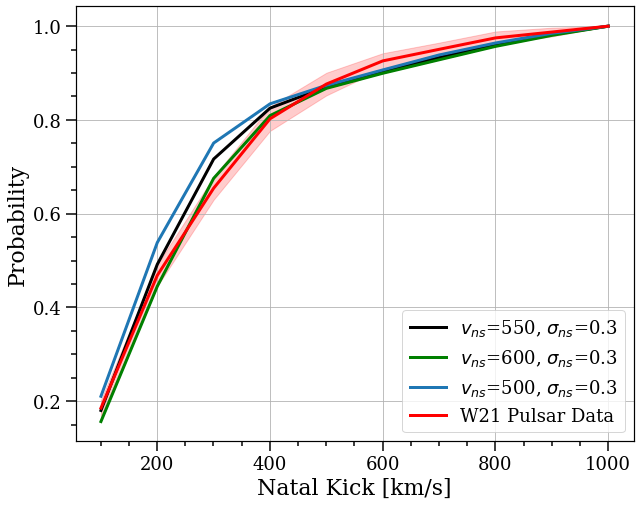

Plot completed in 3.680393 s


In [14]:
# sns.set()
n_bins = 10

n_cdf = 1
n_cdf_posterior = 100

n_draws = 500000
posterior_draws = 89

start = time.time()


f, ax= plt.subplots(1, 1,  figsize=(10,8)) 

lw=3

lpf.plot_model_cdf(*PLOT_DATA, n_cdf, MAX_INDICES[0], label=labels[0], n_draws=n_draws, color='k', alpha=1, lw=lw)
lpf.plot_model_cdf(*PLOT_DATA, n_cdf, MAX_INDICES[1], label=labels[1], n_draws=n_draws, color='g', alpha=1, lw=lw)
lpf.plot_model_cdf(*PLOT_DATA, n_cdf, MAX_INDICES[2], label=labels[2], n_draws=n_draws, color='C0', alpha=1, lw=lw)


lpf.plot_avg_posterior_cdf(*PLOT_DATA, n_cdf_posterior, n_bins=n_bins, n_draws=posterior_draws, color='r', lw=lw, label="W21 Pulsar Data")


layoutAxes(ax=ax, fontsize=fm)
plt.xlabel('Natal Kick [km/s]', fontsize=fl)
plt.ylabel('Probability', fontsize=fl)

plt.legend(fontsize=fm)
    
    
# plt.semilogx()
plt.grid()
# plt.savefig('plots/model_cdfs_bse.pdf')
plt.show()


end = time.time()
print(f"Plot completed in {end - start:2f} s")

# Comparison to Hobbs Maxwellian

In [17]:
from scipy.stats import maxwell

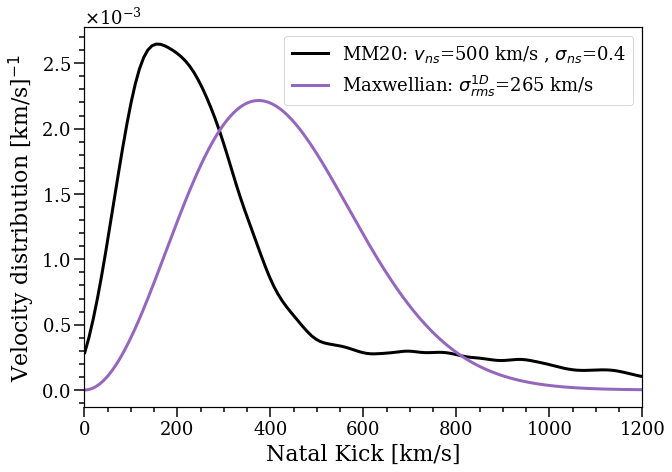

In [24]:
f, ax= plt.subplots(1, 1,  figsize=(10,7)) 

best_index = np.intersect1d(kick_models["NS_500_RANGE"], kick_models["SIGMA_0.4_RANGE"])[0]

kde_best = gaussian_kde( NS_KICKS_3D[best_index] )
kde_best_dist_space = linspace( min(NS_KICKS_3D[best_index]), max(NS_KICKS_3D[best_index]), 300 )
label_str = r'MM20: $v_{ns}$=' + '{nskick}'.format(nskick=NS_KICK_MULT[best_index]) + ' km/s , $\sigma_{ns}$=' + '{sig}'.format(sig=SIGMAS[best_index])

plt.plot( kde_best_dist_space, kde_best(kde_best_dist_space), 'k', lw=3, label=label_str)

x = np.linspace(0, 1200, 500)
plt.plot(x, maxwell.pdf(x, 0, 265), 'tab:purple', lw=3, label='Maxwellian: $\sigma_{rms}^{1D}$=265 km/s')

plt.rc('font', size=fm)

plt.ticklabel_format(axis='y', style='sci',scilimits=(0,0), useMathText=True)

plt.xlim(0, 1200)

layoutAxes(ax=ax, fontsize = fm)
plt.xlabel('Natal Kick [km/s]', fontsize=fl)
plt.ylabel('Velocity distribution [km/s]$^{-1}$', fontsize=fl)
plt.ticklabel_format(axis='y', style='sci',scilimits=(0,0))

plt.legend(fontsize=fm, loc='best')

plt.savefig('plots/hobbs_vs_best.pdf')


# CDF Comparisons

In [15]:
# Get all the cdfs needed for KS test
n_cdf = 1
n_bins = 30
n_draws = 10000
bins, cdf_0, cdf_min, cdf_max, draws  = lpf.get_avg_model_cdf(*PLOT_DATA, n_cdf, MAX_INDICES[0], n_bins=n_bins, n_draws=n_draws)
bins, cdf_1, cdf_min, cdf_max, draws  = lpf.get_avg_model_cdf(*PLOT_DATA, n_cdf, MAX_INDICES[1], n_bins=n_bins, n_draws=n_draws)
bins, cdf_2, cdf_min, cdf_max, draws  = lpf.get_avg_model_cdf(*PLOT_DATA, n_cdf, MAX_INDICES[2], n_bins=n_bins, n_draws=n_draws)

bins_posterior, cdf_posterior, cdf_pos_min, cdf_pos_max, draws = lpf.get_avg_posterior_cdf(*PLOT_DATA, n_cdf=500, n_bins=n_bins)


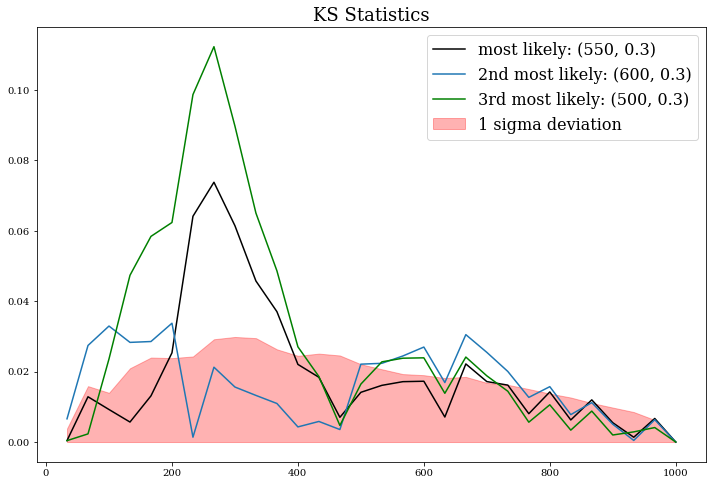

In [16]:
# Plot the KS-statistics

f, ax= plt.subplots(1, 1,  figsize=(12,8)) 
plt.plot(bins, np.abs(cdf_0 - cdf_posterior), color='k', label=f'most likely: ({NS_KICK_MULT[MAX_INDICES[0]]}, {SIGMAS[MAX_INDICES[0]]})')
plt.plot(bins, np.abs(cdf_1 - cdf_posterior), color='C0', label=f'2nd most likely: ({NS_KICK_MULT[MAX_INDICES[1]]}, {SIGMAS[MAX_INDICES[1]]})')
plt.plot(bins, np.abs(cdf_2 - cdf_posterior), color='g', label=f'3rd most likely: ({NS_KICK_MULT[MAX_INDICES[2]]}, {SIGMAS[MAX_INDICES[2]]})')

plt.fill_between(bins, 0, cdf_pos_max - cdf_posterior, color='r', alpha=0.3, label='1 sigma deviation')

plt.title("KS Statistics", fontsize=fm)

plt.legend(fontsize=fs)
plt.show()